# A recurrent neural network for solving a perceptual decision making task

### Evaluating the hidden dimensions of a recurrent network needed to solve a perceptual decision making task and whether training the recurrent connections are necessary for solving the task

In [47]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('default')
import tensorflow as tf
from matplotlib import cm
import pandas as pd
import numpy as np
import math
import gym
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import neurogym as ngym
from sklearn.decomposition import PCA
import pickle

## Create the behavioral task environment

In [15]:
task_name = 'PerceptualDecisionMaking-v0'

kwargs = {'dt': 50, 'timing': {'stimulus': 1000}, 'dim_ring':2}

env = gym.make(task_name, **kwargs)

seq_len = 24
batch_size = 16
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)

In [104]:
# observations space diemsions
obs_size = env.observation_space.shape[0]
print('observation space has',  obs_size, 'dimensions')

# action space dimensions 
act_size = env.action_space.n
print('action space has',  act_size, 'dimensions')


observation space has 3 dimensions
action space has 3 dimensions


##### generate an example batch to visulaize the input output mapping 


In [105]:
steps_per_epoch = 1
data_generator = (dataset() for i in range(steps_per_epoch))
x = next(data_generator)

<Figure size 144x720 with 0 Axes>

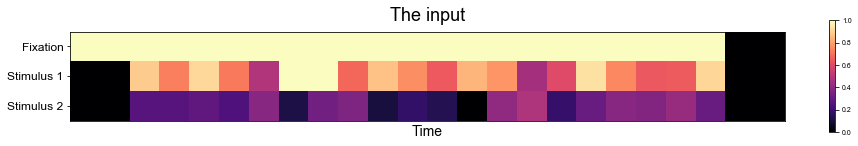

In [124]:
id = 9
plt.figure(figsize=(2,10))
plt.matshow(x[0][:,id].T, vmin=0, vmax=1, cmap=cm.magma)
plt.xticks([]);
plt.yticks(range(3), ['Fixation', 'Stimulus 1', 'Stimulus 2'], fontsize=12);
plt.xlabel('Time', fontsize=14)
plt.title('The input', fontsize=18)
plt.colorbar();

In [129]:
print('Average intensity for stimulus 1 and 2 are',
      *[round(x,2) for x in np.mean(x[0][:,id], axis=0)[1:]],
      'respectively')
print('The ground truth is stimulus', np.argmax(np.mean(x[0][:,id][1:], axis=0))+1)

Average intensity for stimulus 1 and 2 are 0.65 0.23 respectively
The ground truth is stimulus 1


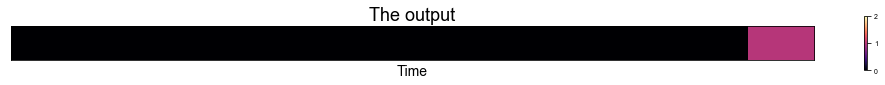

In [131]:
plt.figure(figsize=(18,1))
plt.imshow(np.expand_dims(x[1][:,id], 0), vmin=0, vmax=2, cmap=cm.magma)
plt.xticks([]);
plt.yticks([]);
plt.xlabel('Time', fontsize=14)
plt.title('The output', fontsize=18)
plt.colorbar();

### Defining model creating and training functions

In [45]:
def create_rnn(h_dim, output_only=False):
    '''
    h_dim: the hidden dimensionality of the RNN
    output_only: define whether the recurrent connections are trained or left frozen at its random weights
    '''
    inputs = tf.keras.layers.Input(batch_shape=(None, None, obs_size), dtype='float32')
    x = tf.keras.layers.SimpleRNN(h_dim,
                                  activation='tanh',
                                  return_sequences=True,
                                  time_major=True,
                                  stateful=False)(inputs)
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(act_size, activation='softmax'))(x)
    model = tf.keras.models.Model(inputs, outputs)
    if output_only:
        model.layers[1].trainable = False
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model


        
def train_rnn(model, no_batches):
    '''
    model: the initialized model
    no_batches: number of data batches to generate for training
    '''
    class BCP(tf.keras.callbacks.Callback):
        batch_accuracy = [] 
        batch_loss = []
        def __init__(self):
            super(BCP,self).__init__() 
        def on_train_batch_end(self, batch, logs=None):                
            BCP.batch_accuracy.append(logs.get('accuracy'))
            BCP.batch_loss.append(logs.get('loss'))
        
    data_generator = (dataset() for i in range(no_batches))
    history = model.fit(data_generator, steps_per_epoch=no_batches, verbose=0, callbacks=[BCP()])
    return model, (BCP.batch_loss, BCP.batch_accuracy)

def compute_performance(model, activity_model, num_trial=100):
    '''
    model: the full trained model to be evaluated 
    activity_model: the trained model without the readout layer
    num_trials: number of trials to be used for evaluation
    
    '''
    env = dataset.env
    env.reset(no_step=True)

    perf = 0
    trial_infos = {}
    action_predictions = []
    hidden_states = []
    for i in range(num_trial):

        trial_info = env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = ob[:, np.newaxis, :]
        action_pred = model.predict(inputs)
        action_predictions.append(action_pred)
        h = activity_model.predict(inputs)
        hidden_states.append(h)
        choice = np.argmax(action_pred[-1, :])
        correct = choice == gt[-1]
        trial_infos[i] = trial_info  # trial_info is a dictionary
        trial_infos[i].update({'correct': correct})

    return np.mean([val['correct'] for val in trial_infos.values()]), np.array(action_predictions), np.array(hidden_states), trial_infos

# Training

### I train 16 RNNs with hidden dimensionalities [1,2,4,8,16,32,64,128] with either the recurrent connectivity matrix kept random or trained

In [46]:

NO_ITERATIONS = 100              #100 checkpoints in each I train on 100 batches
performances = {x:[[],[]] for x in [2**x for x in range(8)]}
all_metrics = {x:[[],[]] for x in [2**x for x in range(8)]}
all_action_predictions = {x:[[],[]] for x in [2**x for x in range(8)]}
all_hidden_states = {x:[[],[]] for x in [2**x for x in range(8)]}
all_trial_infos = {x:[[],[]] for x in [2**x for x in range(8)]}

for h_dim in [2**x for x in range(8)]:
    for flag in [True, False]:
        print('working on', h_dim, int(flag))
        tf.keras.backend.clear_session()
        model = create_rnn(h_dim, output_only=flag)
        for i in range(NO_ITERATIONS):

            model, metrics = train_rnn(model, 100)
            activity_model = tf.keras.models.Model(model.inputs, model.layers[1].output)

            perf, action_predictions, hidden_states, trial_infos = compute_performance(model, activity_model)

            performances[h_dim][int(flag)].append(perf)
            all_metrics[h_dim][int(flag)].append(metrics)
        all_action_predictions[h_dim][int(flag)] = action_predictions
        all_hidden_states[h_dim][int(flag)] = hidden_states
        all_trial_infos[h_dim][int(flag)] = trial_infos


working on 1 1


C:\Users\farahata\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:820: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (isinstance(inputs, collections.Sequence)
C:\Users\farahata\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
C:\Users\farahata\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\data_structures.py:718: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


working on 1 0
working on 2 1
working on 2 0
working on 4 1
working on 4 0
working on 8 1
working on 8 0
working on 16 1
working on 16 0
working on 32 1
working on 32 0
working on 64 1
working on 64 0
working on 128 1
working on 128 0


In [48]:
#saving the data

with open('performances.pickle', 'wb') as handle:
    pickle.dump(performances, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('all_metrics.pickle', 'wb') as handle:
    pickle.dump(all_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('all_action_predictions.pickle', 'wb') as handle:
    pickle.dump(all_action_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('all_hidden_states.pickle', 'wb') as handle:
    pickle.dump(all_hidden_states, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('all_trial_infos.pickle', 'wb') as handle:
    pickle.dump(all_trial_infos, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plotting the results

### Plotting the performance of the networks over training time

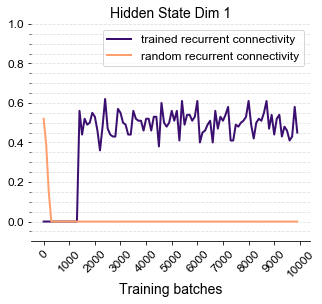

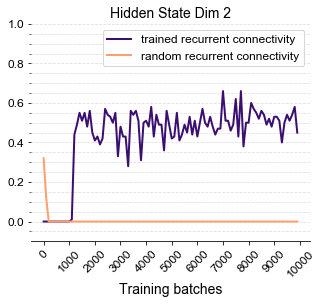

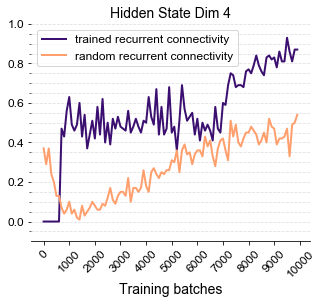

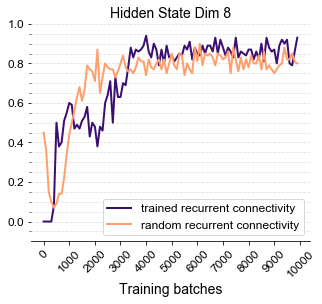

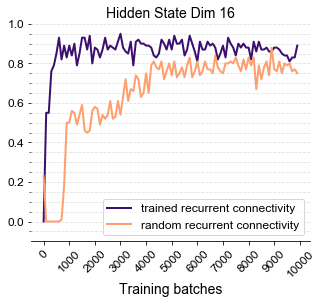

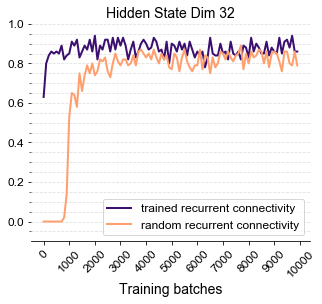

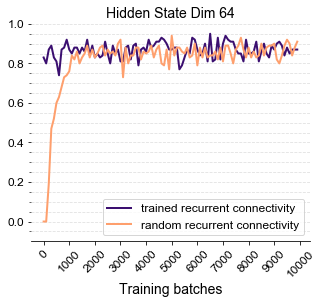

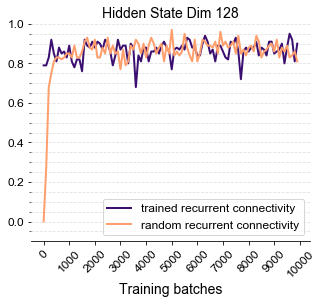

In [143]:
for i in [2**x for x in range(8)]:
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(5)
    plt.plot(performances[i][0], linewidth=2, label='trained recurrent connectivity', color=cm.magma(0.2))
    plt.plot(performances[i][1], linewidth=2, label='random recurrent connectivity', color=cm.magma(0.8))
    plt.legend(fontsize=12)
    plt.ylim([-0.1,1])
    plt.title('Hidden State Dim '+str(i), fontsize=14)
    plt.xticks(np.arange(0,101,10), np.arange(0,101,10)*100, fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.grid(b=True, which='major', color='#999999', linestyle='--', alpha=0.3, axis='y')
    plt.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=False)
    plt.xlabel('Training batches', fontsize=14)
    plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.3, axis='y')
    plt.savefig('performances_'+str(i)+'.png', dpi=600)

### Plotting the hidden state of the RNN units over time to observe how they itegrate the input to differentiate between the two stimuli

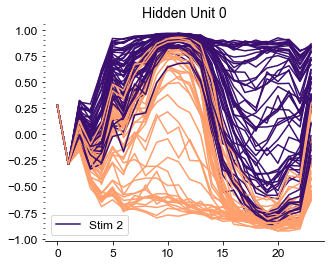

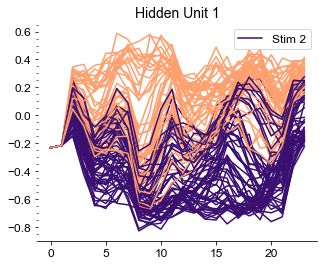

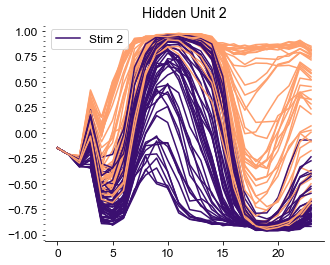

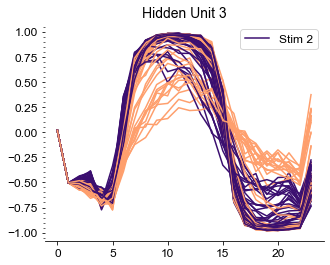

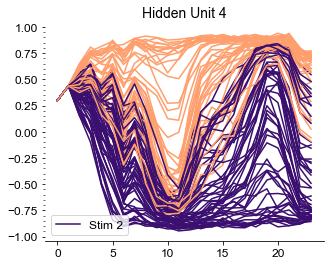

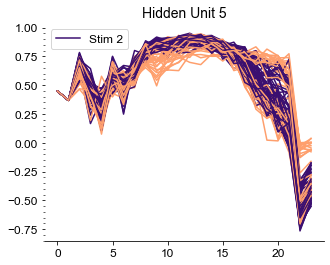

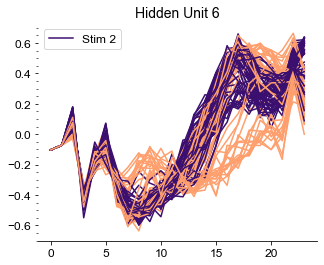

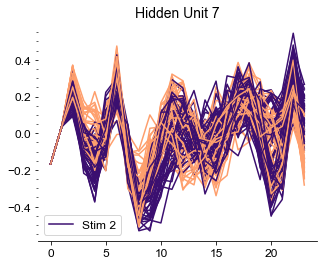

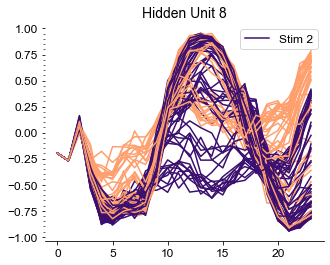

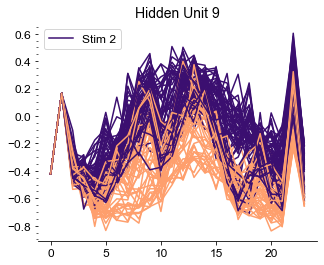

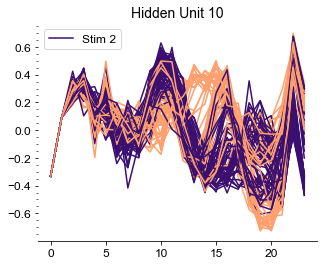

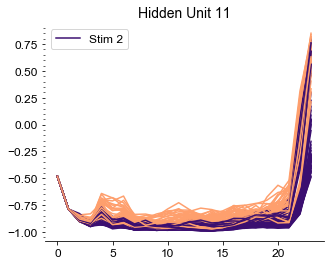

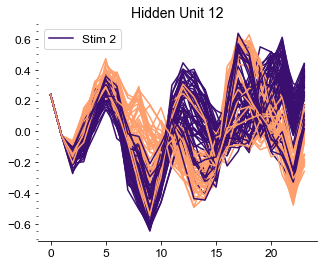

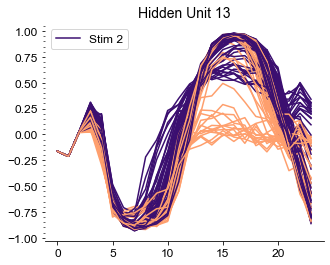

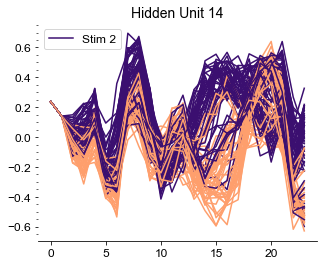

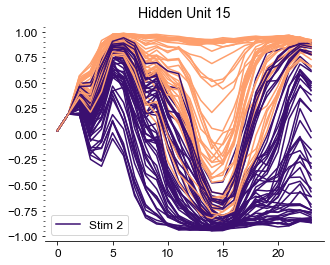

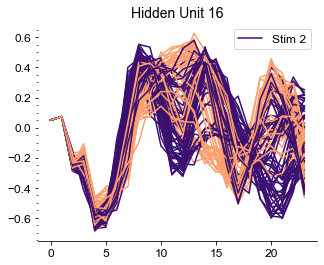

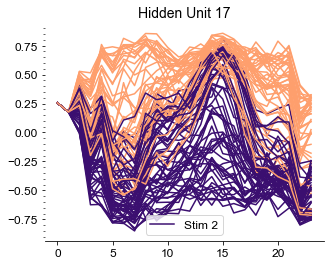

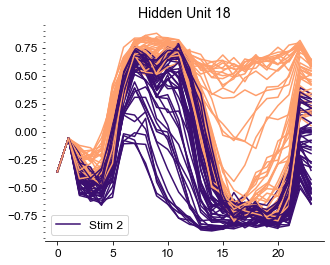

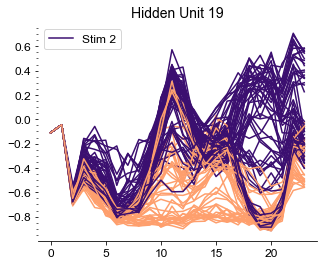

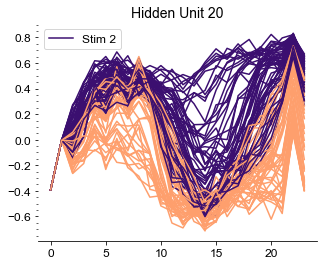

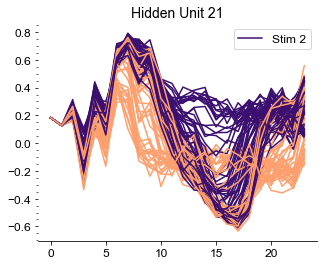

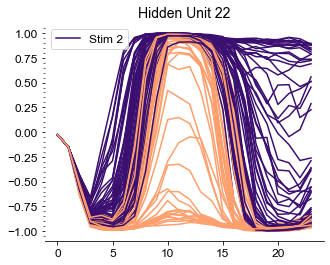

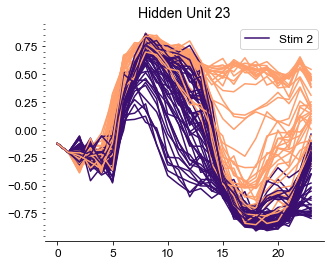

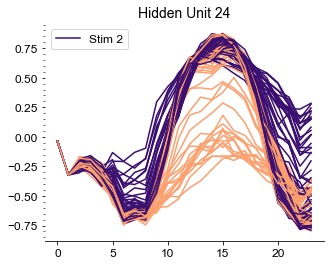

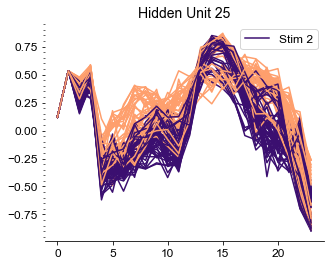

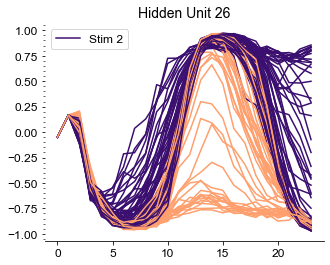

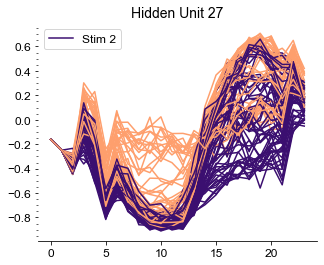

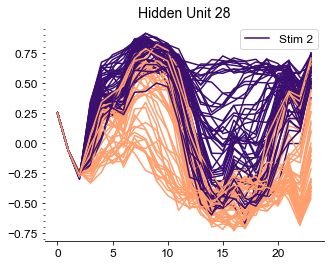

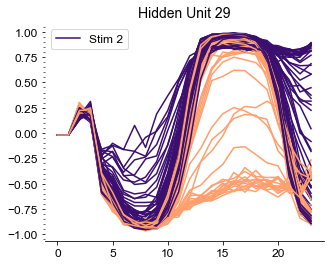

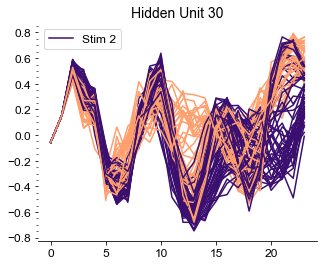

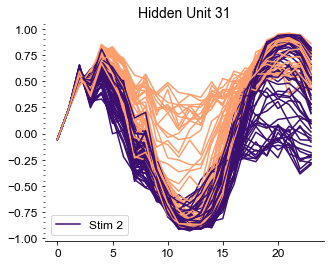

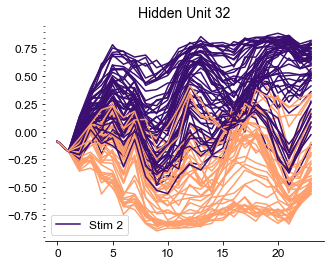

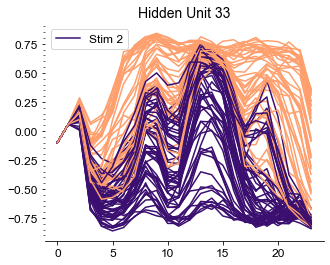

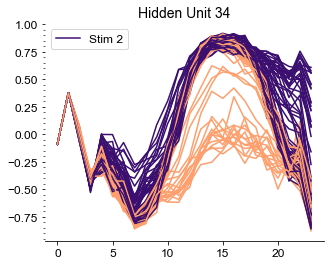

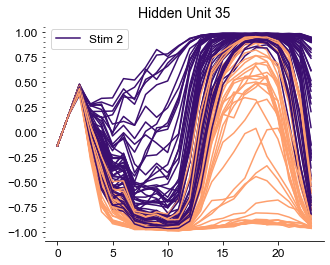

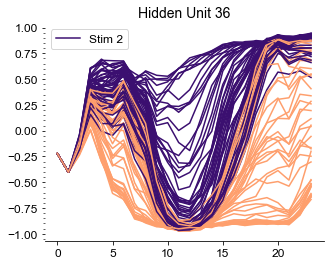

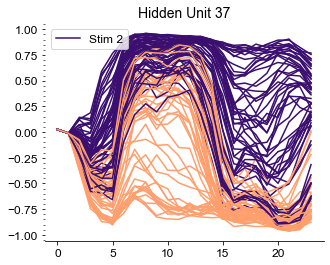

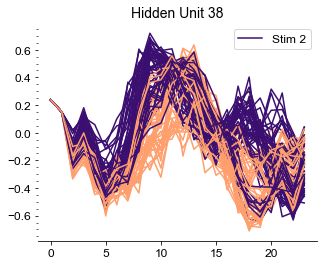

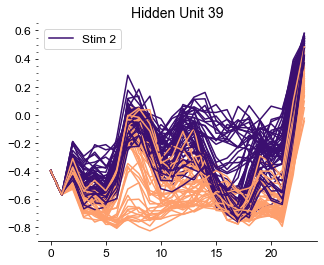

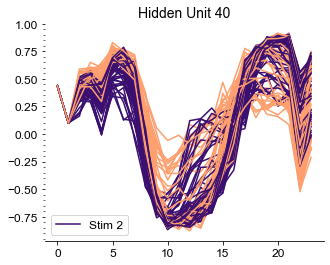

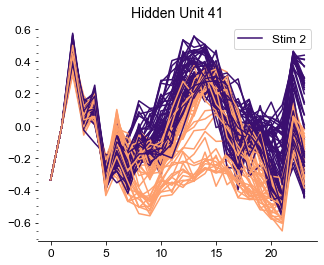

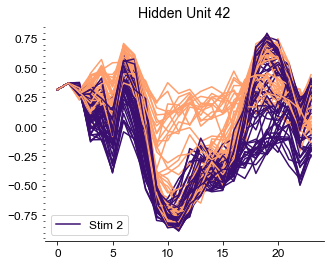

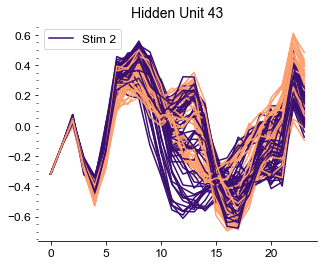

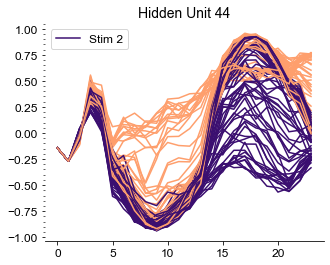

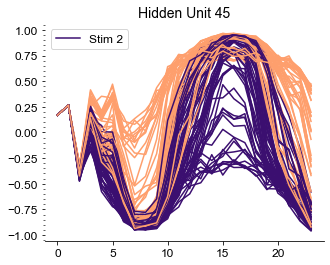

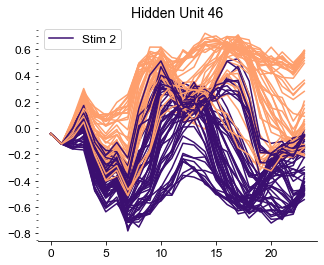

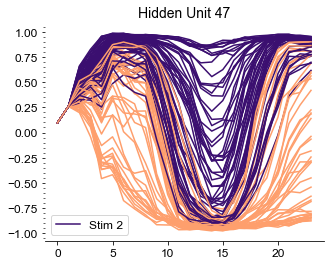

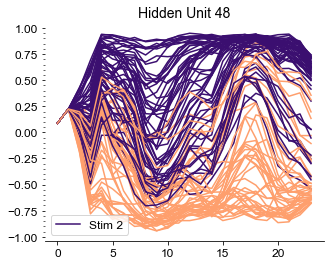

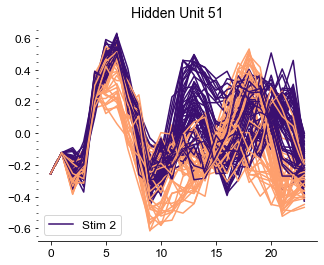

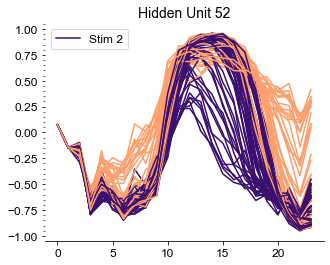

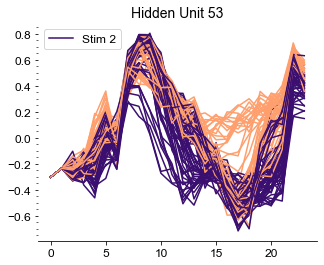

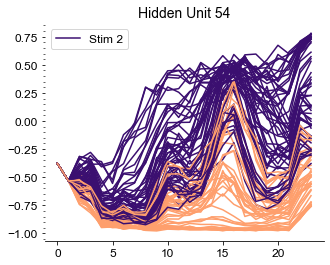

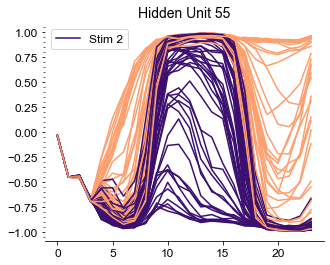

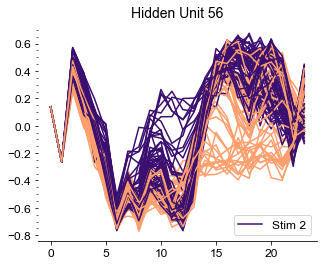

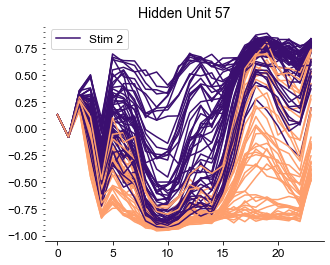

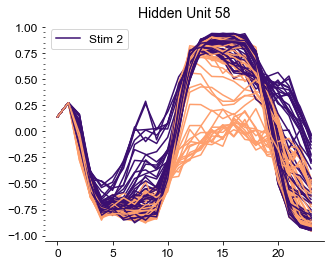

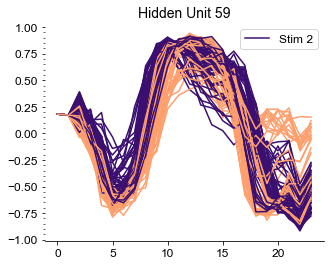

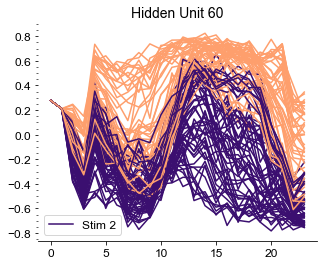

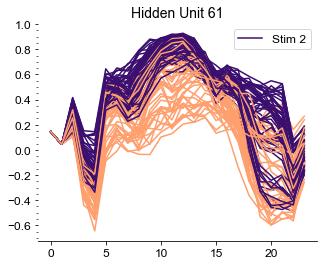

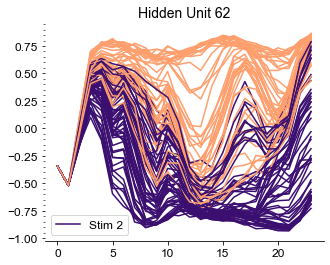

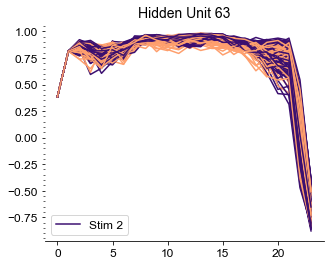

In [72]:
flag = 0       # 0 for trained recurrent connectivity and 1 for random recurrent connectivity
h_dim = 64     # the hidden dimenisonality of the network


for flag in [flag]:
    for k in [h_dim]:
        for j in range(k):
            fig, ax = plt.subplots()
            fig.set_figheight(4)
            fig.set_figwidth(5)
            for i in range(100):
                gt = all_trial_infos[k][flag][i]['ground_truth']
            
                color = cm.magma(0.2) if gt == 1 else cm.magma(0.8)
#                 color = cm.magma(0.2) if np.argmax(all_action_predictions[k][flag][i,-1,0,:]) == 1 else cm.magma(0.8)
                if i==0:
                    label = 'Stim 1' if np.argmax(all_action_predictions[k][flag][i,-1,0,:]) == 1 else 'Stim 2'
                    plt.plot(all_hidden_states[k][flag][i,:,0,j], label= label, color=color)
                else:
                    plt.plot(all_hidden_states[k][flag][i,:,0,j], color=color)
            plt.legend(fontsize=12)
    #         plt.ylim([-0.1,1])
            plt.title('Hidden Unit '+str(j), fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    #         plt.grid(b=True, which='major', color='#999999', linestyle='--', alpha=0.3, axis='y')
            plt.minorticks_on()
            ax.tick_params(axis='x', which='minor', bottom=False)

    #         plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.3, axis='y')
            plt.savefig('plots/hidden_units_rnn_'+str(k)+'_'+str(flag)+'_'+str(j)+'.png', dpi=600)
            plt.show()

### in order to observe the development of the hidden state of the networks over time in one plot instead of plotting each hidden unit separately, we use PCA to reduce the domensionality of the hidden stat to 2.

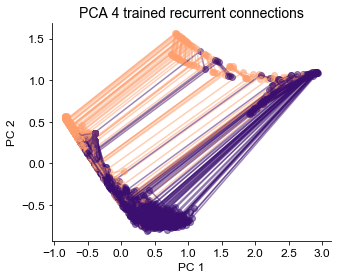

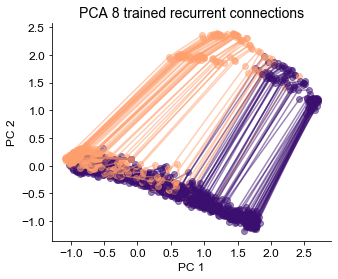

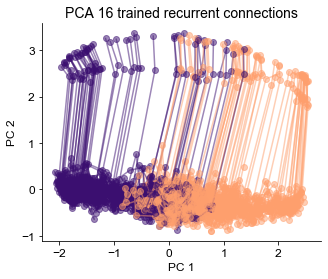

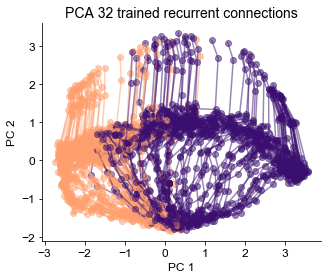

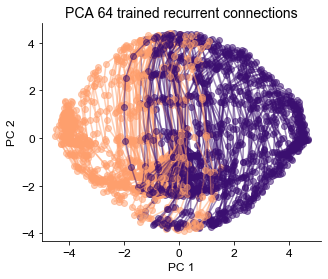

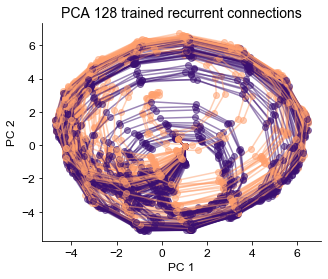

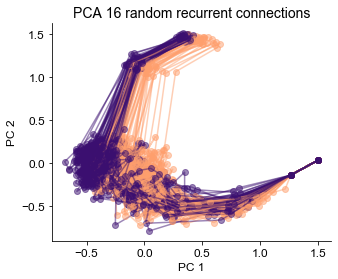

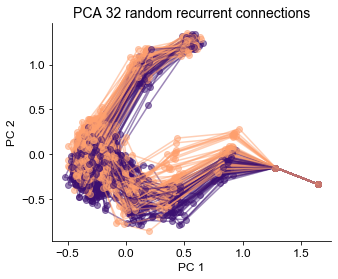

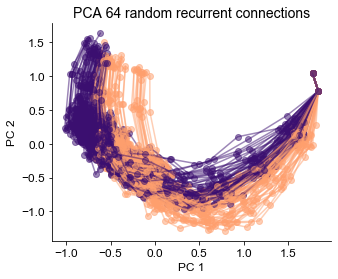

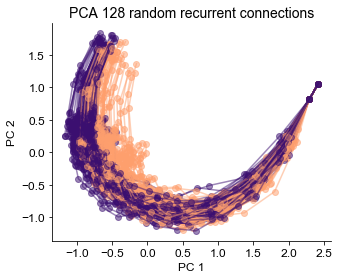

In [69]:
for flag in [0,1]:
    for k in [2**x for x in range(1,8,1)]:
    
        activity = np.concatenate(list(all_hidden_states[k][flag][i] for i in range(100)), axis=0)
        activity = activity.squeeze()
        if k!=2:
            pca = PCA(n_components=2)
            pca.fit(activity)  # activity (Time points, Neurons)
            activity_pc = pca.transform(activity)  # transform to low-dimension
        else:
            activity_pc = activity
        # fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(20, 10))
        fig, ax = plt.subplots()
        fig.set_figheight(4)
        fig.set_figwidth(5)
        for i in range(100):
            # Transform and plot each trial
            if k!=2:
                activity_pc = pca.transform(all_hidden_states[k][flag][i].squeeze())  # (Time points, PCs)
            else:
                activity_pc = all_hidden_states[k][flag][i].squeeze()
            gt = all_trial_infos[k][flag][i]['ground_truth']
        #     print(trial['ground_truth'])
            
            color = cm.magma(0.2) if gt == 1 else cm.magma(0.8)
#             color = cm.magma(0.2) if np.argmax(all_action_predictions[k][flag][i,-1,0,:]) == 1 else cm.magma(0.8)

            _ = ax.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.5)
        #     if i < 5:
        #         _ = ax2.plot(activity_pc[:,0], activity_pc[:, 1], 'o-', color=color)

            # Plot the beginning of a trial with a special symbol
        #         _ = ax2.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')
        #         _ = ax2.plot(activity_pc[-1, 0], activity_pc[-1, 1], '^', color='green')

#         ax.set_title('{:d} Trials'.format(100))
        # ax2.set_title('{:d} Trials'.format(3))
        ax.set_xlabel('PC 1', fontsize=12)
        ax.set_ylabel('PC 2', fontsize=12)
#         plt.legend(fontsize=12)
#         plt.ylim([-0.1,1])
        if flag:
        
            plt.title('PCA '+str(k)+' random recurrent connections', fontsize=14)
        else:
            plt.title('PCA '+str(k)+' trained recurrent connections', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         plt.grid(b=True, which='major', color='#999999', linestyle='--', alpha=0.3, axis='y')
#         plt.minorticks_on()
        ax.tick_params(axis='x', which='minor', bottom=False)

#         plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.3, axis='y')
        plt.savefig('plots/pca_'+str(k)+'_'+str(flag)+'.png', dpi=600)
        plt.show()

### looking at the probabilities of each action as they develop over time to observe when the RNN make a descicion about the stimuli

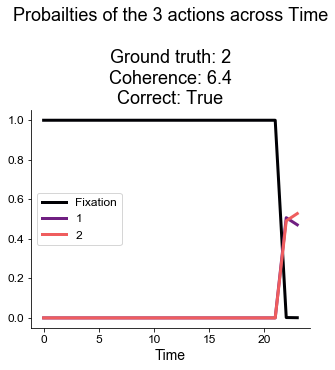

In [138]:
id=1         #trial id
k = 128      #the hidden dimension of the network
flag = 1     # 0 for trained recurrent connectivity and 1 for random recurrent connectivity


fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.plot(all_action_predictions[k][flag][id][:,0,0], lw=3, label = 'Fixation', color = cm.magma(0.0))
plt.plot(all_action_predictions[k][flag][id][:,0,1], lw=3, label = '1', color = cm.magma(0.33))
plt.plot(all_action_predictions[k][flag][id][:,0,2], lw=3, label = '2', color = cm.magma(0.66))
plt.title('Probailties of the 3 actions across Time\n'+
        '\nGround truth: '+ 
          str(all_trial_infos[k][flag][id]['ground_truth']+1)+ 
          '\nCoherence: '+
          str(all_trial_infos[k][flag][id]['coh'])+
          '\nCorrect: '+
          str(all_trial_infos[k][flag][id]['correct']), fontsize=18)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='minor', bottom=False)
plt.xlabel('Time', fontsize=14);